# Analyze cell states vs storage states for Model 1
We want to see if the cell states of Model 1 have learned physically reasonably representations, i.e. storage.

## Data Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

In [2]:
from src.data.data_processing import *
from src.data.data_fetching import *

In [3]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [4]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

### Standardized data

In [5]:
# Run data processing pipeline
pipeline_std = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), 
# test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_std, ts_val_std, ts_test_std = pipeline_std.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_std, X_val_std, X_test_std = ts_train_std[:, :, [0, 3]], ts_val_std[:, :, [0, 3]], ts_test_std[:, :, [0, 3]]
# select outflow as target feature
y_train_std, y_val_std, y_test_std = ts_train_std[:, :, [1]], ts_val_std[:, :, [1]], ts_test_std[:, :, [1]]

### Normalized data

In [6]:
# Run data processing pipeline
pipeline_nm = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1, transform_type='normalize', fill_na_method='mean')
# Train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_nm, ts_val_nm, ts_test_nm = pipeline_nm.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_nm, X_val_nm, X_test_nm = ts_train_nm[:, :, [0, 3]], ts_val_nm[:, :, [0, 3]], ts_test_nm[:, :, [0, 3]]
# select outflow as target feature
y_train_nm, y_val_nm, y_test_nm = ts_train_nm[:, :, [1]], ts_val_nm[:, :, [1]], ts_test_nm[:, :, [1]]

In [7]:
# check lengths of train/val/test sets
original_train_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.train_frac))
original_val_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.val_frac))
original_test_len = df['1944-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

## Model 1a

In [8]:
from src.models.model_zoo import *
from src.models.train_model import *
from src.models.analyze_lstm_cell import *

In [9]:
# instantiate optimal model
input_size = 2
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1
torch.manual_seed(0)
model1a = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers,
                             dropout_prob=dropout_prob)
# load saved model
model1a.load_state_dict(torch.load('src/models/saved_models/model1a.pt'))
# turn model into evaluation model
model1a.eval()

LSTMModel1(
  (lstm_cell_list): ModuleList(
    (0): LSTMCell(2, 30)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=30, out_features=15, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=15, out_features=1, bias=True)
)

In [10]:
# Get storage states, shape is (timesteps, )
storage_train = df.storage[:original_train_len].values
storage_val = df.storage[original_train_len:(original_train_len+original_val_len)].values
storage_test = df.storage[(original_train_len+original_val_len):].values

# Get list of cell states (one for each layer), shape is (# chunks, timesteps, hidden size)
with torch.no_grad():
    cell_train_1a = model1a(X_train_std)[1][1]
    cell_val_1a = model1a(X_val_std)[1][1]
    cell_test_1a = model1a(X_test_std)[1][1]

In [11]:
# Calculate correlations for layer 1
correlation_data = {'training: layer1':cell_correlations(cell_states=cell_train_1a[0], storage_states=storage_train),
                    'validation: layer1': cell_correlations(cell_states=cell_val_1a[0], storage_states=storage_val),
                    'testing: layer1': cell_correlations(cell_states=cell_test_1a[0], storage_states=storage_test)}
df_corr = pd.DataFrame(correlation_data)

# Select cell with |correlation| > 0.40
df_corr.loc[np.abs(df_corr['testing: layer1']) > 0.40, :].sort_values(by='testing: layer1', ascending=False)

,training: layer1,validation: layer1,testing: layer1
20,0.433498,0.630791,0.520652
18,0.412510,0.589280,0.495587
7,0.383135,0.572954,0.482583
29,0.345650,0.562985,0.462216
8,0.308736,0.449045,0.431485
1,-0.362238,-0.489812,-0.452836


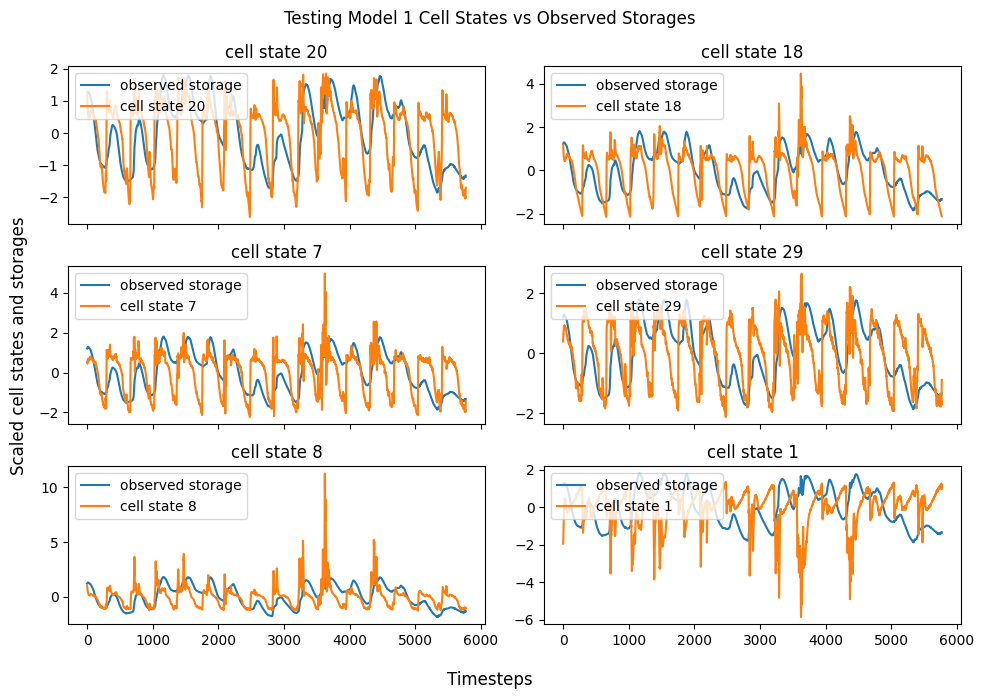

In [12]:
# CHANGE MANUALLY AS NEEDED
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 7), sharex=True)

cell_ids_list = [20, 18, 7, 29, 8, 1]
for i, ax in enumerate(axes.reshape(-1)):
    plot_storage_cell(cell_states_all=cell_test_1a[0], storage_states=storage_test, cell_id=cell_ids_list[i], ax=ax)
    ax.legend(loc='upper left')
    ax.set_title(f'cell state {cell_ids_list[i]}')

fig.supxlabel('Timesteps')
fig.supylabel('Scaled cell states and storages')
fig.suptitle('Testing Model 1 Cell States vs Observed Storages')
plt.tight_layout()
# plt.savefig('report/drafting/2_27_2024/figures/Figure6_cell_states.png', dpi=300)
plt.show()

### What about longer term correlations? (Model 1a)
Try correlating with moving averages to see if cell states correlate with smoothed states

In [48]:
# Get yearly moving average of storage
storage_train_1yrma = pd.DataFrame(storage_train).rolling(window=365).mean().values
storage_val_1yrma = pd.DataFrame(storage_val).rolling(window=365).mean().values
storage_test_1yrma = pd.DataFrame(storage_test).rolling(window=365).mean().values

In [49]:
# Calculate correlations for layer 1 (with 1 year MA storages)
correlation_data_1yrma = {'training: layer1':cell_correlations(cell_states=cell_train_1a[0], storage_states=storage_train_1yrma),
                    'validation: layer1': cell_correlations(cell_states=cell_val_1a[0], storage_states=storage_val_1yrma),
                    'testing: layer1': cell_correlations(cell_states=cell_test_1a[0], storage_states=storage_test_1yrma)}
df_corr_1yrma = pd.DataFrame(correlation_data)

# Select cell with correlation > 0.30
df_corr_1yrma.loc[df_corr['training: layer1'] > 0.40, :].sort_values(by='testing: layer1', ascending=False)

,training: layer1,validation: layer1,testing: layer1
20,0.433498,0.630791,0.520652
18,0.412510,0.589280,0.495587


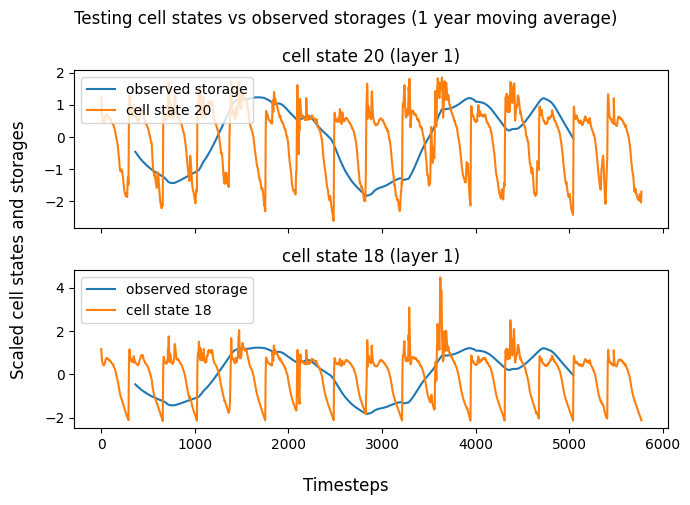

In [51]:
# CHANGE MANUALLY AS NEEDED
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)
plot_storage_cell(cell_states_all=cell_test_1a[0], storage_states=storage_test_1yrma, cell_id=20, ax=axes[0])
plot_storage_cell(cell_states_all=cell_test_1a[0], storage_states=storage_test_1yrma, cell_id=18, ax=axes[1])
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[0].set_title('cell state 20 (layer 1)')
axes[1].set_title('cell state 18 (layer 1)')
fig.supxlabel('Timesteps')
fig.supylabel('Scaled cell states and storages')
fig.suptitle('Testing cell states vs observed storages (1 year moving average)')
plt.tight_layout()
plt.show()